Ada dua jenis klasifikasi: klasifikasi binari dan klasifikasi multikelas. Perbedaan dari dua tipe klasifikasi ini ada pada jumlah kelas variabel target; pada klasifikasi binari, ada dua kelas, biasa kita kenal sebagai kelas 0 dan 1, sedangkan pada klasifikasi multikelas variabel target memiliki lebih dari dua kelas. Klasifikasi binari dan klasifikasi multikelas memiliki proses yang mirip, namun, karena perbedaan jumlah kelas di variabel target, tentunya ada perbedaan pada metrik evaluasi performa model. 

Di notebook ini, saya akan membahas klasifikasi multikelas dan metrik evaluasinya, terutama _confusion matrix_.

In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest, kruskal, chi2_contingency

# Data

Dataset yang saya pakai adalah dataset _Mobil Price Classification_ yang diambil dari [kaggle](https://www.kaggle.com/iabhishekofficial/mobile-price-classification). Ada 20 fitur berupa spesifikasi dari telepon genggam dan *price_range* sebagai variabel target dengan 4 kelas di dalamnya. 

In [62]:
df= pd.read_csv('mobile price.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


Berikut adalah fitur di dataset yang dipakai beserta penjelasannya:
* battery_power: Total energi yang bisa disimpan baterai dalam mAh  
* blue: memiliki *bluetooth* atau tidak
* clock_speed: Kecepatan *microprocessor* mengeksekusi instruksi
* dual_sim: Memiliki *dual sim* atau tidak
* fc: Mega pixel kamera depan
* four_g: Memiliki 4G atau tidak
* int_memory: Memori internal dalam _Gigabytes_
* m_dep: Ketebalan telepon genggam dalam cm
* mobile_wt: berat dari telepon genggam
* n_cores: jumlah *cores* dari *processor*
* pc: Mega pixel kamera utama
* px_height: Panjang resolusi pixel 
* px_width: Lebar Resolusi pixel
* ram: Ukuran RAM dalam _Megabytes_
* sc_h: Panjang layar dalam cm
* sc_w: Lebar layar dalam cm
* talk_time: WAktu terlama sekali isi baterai bisa bertahan
* three_g: Memiliki 3G atau tidak
* touch_screen: Memiliki layar sentuh atau tidak
* wifi: memiliki *wifi* atau tidak
* price_range: Variabel target, dengan nilai kelas 0(*low cost*), 1(*medium cost*), 2(*high cost*) and 3(*very high cost*)




# EDA
Sebelum kita masuk ke pembuatan model, kita perlu mengenal dataset kita lebih lanjut. Untuk itu, saya akan melakukan _Explanatory Data Analysis_ sederhana yang bertujuan untuk mengenal fitur-fitur pada dataset dan hubungannya dengan variabel target.

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Dataset _Mobile Price Classification_ memiliki 21 kolom dengan 2000 baris data.  
Semua kolom pada dataset ini sudah berupa numerik, sehingga _encoding_ tidak perlu dilakukan. Perlu diperhatikan, bahwa kolom `blue`,`dual_sim`,`four_g`,`three_g`,`touch_screen` dan `wifi` memiliki nilai kategorikal, walaupun berisi nilai numerik.

Beikut adalah ringkasan singkat statistik deskripsi dari dataset _Mobil Price Classification_:

In [64]:
df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [65]:
df['price_range'].value_counts()

3    500
2    500
1    500
0    500
Name: price_range, dtype: int64

Target dari klasifikasi harga telepon genggam kali ini adalah kolom *price_range*. Dari hasil di atas, bisa dilihat bahwa kolom *price_range* memiliki 4 kategori yang jumlahnya seimbang.  



Eksplorasi berikutnya akan dibagi berdasarkan tipe nilai dari kolom fitur dataset, yaitu, numerik dan kategorikal.

## Numerik

Kolom numerik di datasetr ini terdiri dari:  
`battery_power`,`clock_speed`,`fc`,`int_memory`,`n_cores`,`pc`,`ram`,`px_height`,`px_width`,`sc_h`,`sc_w`,`talk_time`,`mobile_wt`, dan `m_dep`.

Mari kita lihat distribusi data dan hubungan fitur-fitur berikut dengan data target.

battery_power


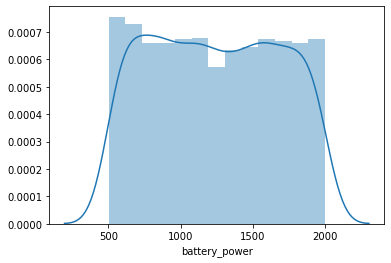

tidak normal

clock_speed


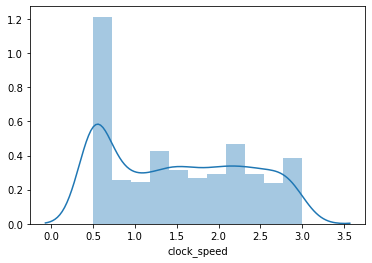

tidak normal

fc


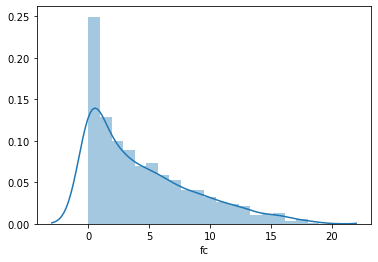

tidak normal

int_memory


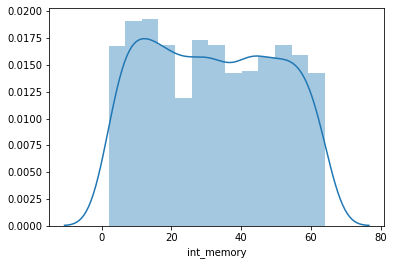

tidak normal

n_cores


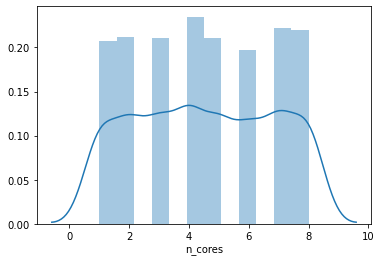

tidak normal

pc


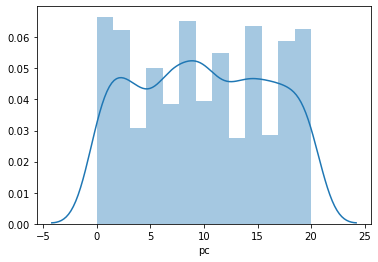

tidak normal

ram


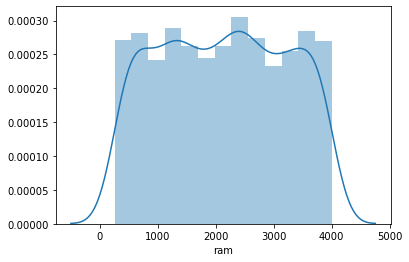

tidak normal

px_height


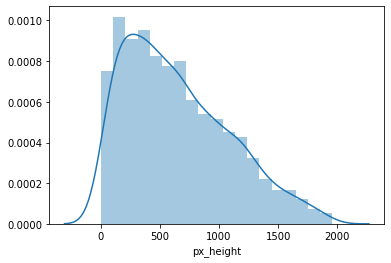

tidak normal

px_width


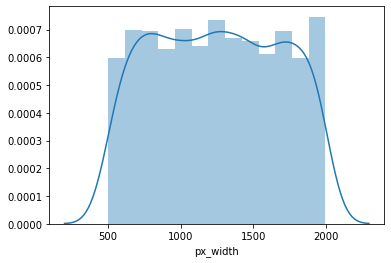

tidak normal

sc_h


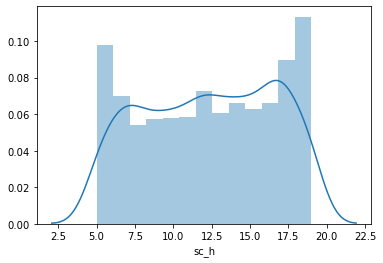

tidak normal

sc_w


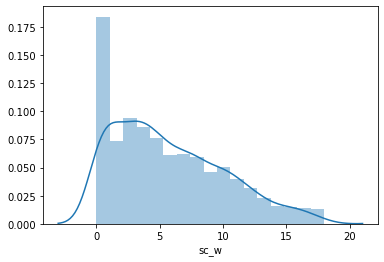

tidak normal

talk_time


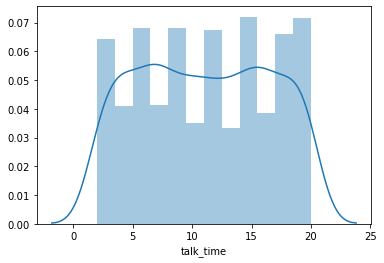

tidak normal

mobile_wt


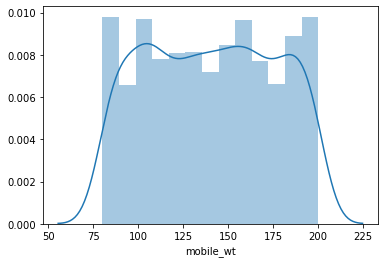

tidak normal

m_dep


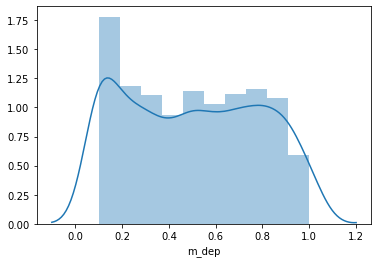

tidak normal



In [66]:
non_cat=['battery_power','clock_speed','fc','int_memory','n_cores','pc','ram','px_height','px_width','sc_h','sc_w','talk_time','mobile_wt','m_dep']

for i in non_cat:
    s,p=normaltest(df[i])
    print(i)
    sns.distplot(df[i])
    plt.show()
    if p>=0.05:
        print('normal')
    else:
        print('tidak normal\n')

Semua kolom numerik memiliki distribusi tidak normal. Sebagian besar kolom memiliki distribusi distribusi uniform, dengan beberapa -- `fc`, `px_height` dan `sc_w`, memiliki distribusi yang condong ke kanan. 

In [67]:
def outlier(data):
    q1=data.quantile(0.25)
    q3=data.quantile(0.75)
    iqr=q3-q1
    b_bawah=q1-1.5*iqr
    b_atas=q3+1.5*iqr
    return data.loc[(data<b_bawah)|(data>b_atas)]

Jumlah outlier battery_power : 0


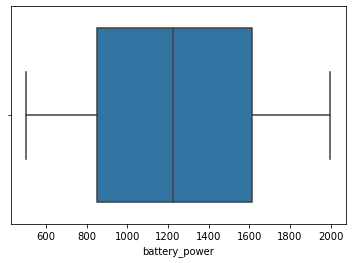

Jumlah outlier clock_speed : 0


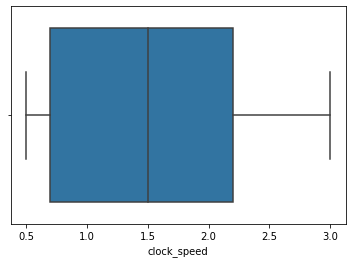

Jumlah outlier fc : 18


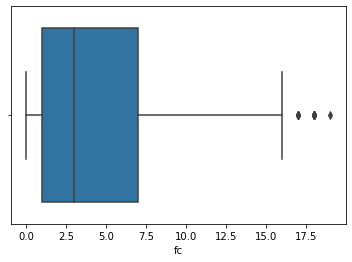

Jumlah outlier int_memory : 0


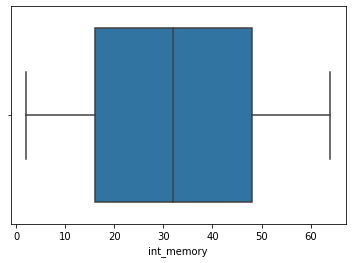

Jumlah outlier n_cores : 0


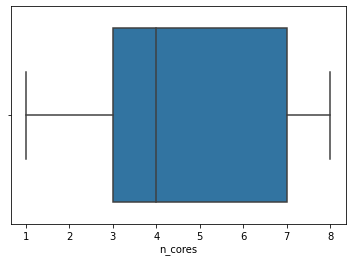

Jumlah outlier pc : 0


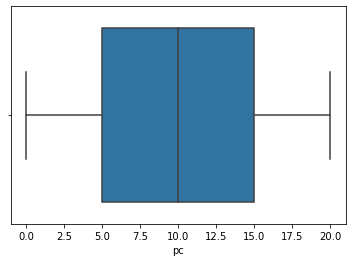

Jumlah outlier ram : 0


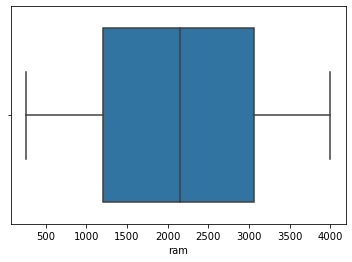

Jumlah outlier px_height : 2


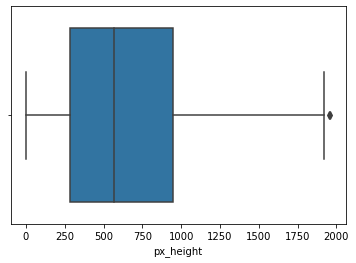

Jumlah outlier px_width : 0


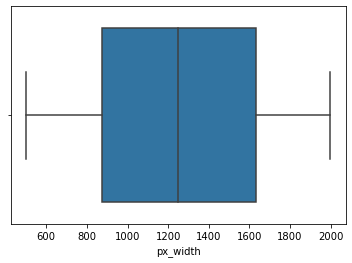

Jumlah outlier sc_h : 0


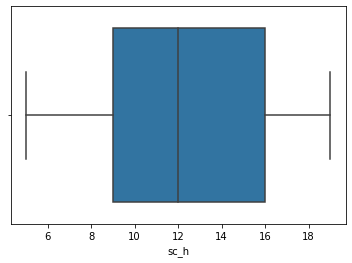

Jumlah outlier sc_w : 0


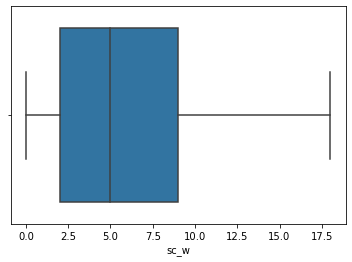

Jumlah outlier talk_time : 0


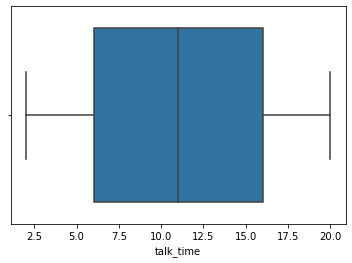

Jumlah outlier mobile_wt : 0


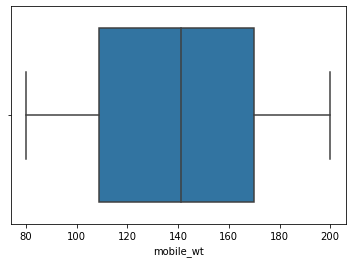

Jumlah outlier m_dep : 0


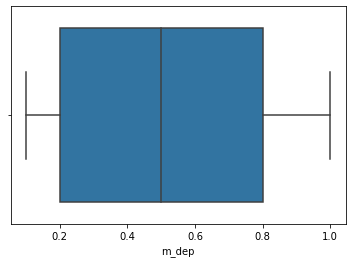

In [68]:
for i in non_cat:
    print('Jumlah outlier',i,':',len(outlier(df[i])))
    
    sns.boxplot(df[i])
    plt.show()

Dari semua kolom, hanya kolom `fc` dan `px_height` yang memiliki pencilan. Jumlah pencilan yang ada pun tidak banyak, sehingga bisa diabaikan.   

Sekarang, mari kita cek, apakah ada perbedaan nilai fitur berdasarkan kelas `price_range`. Karena distribusi data tidak normal, kama saya menggunakan uji _Kruskal Wallis_.

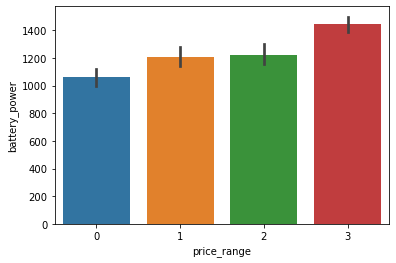

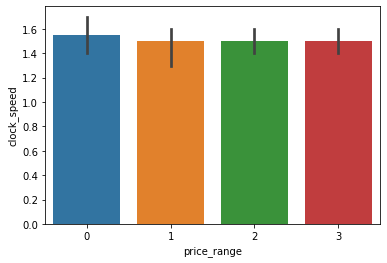

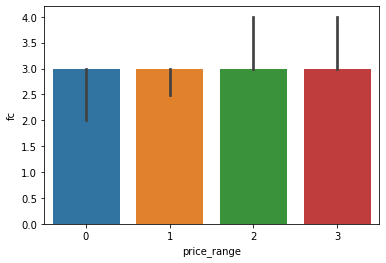

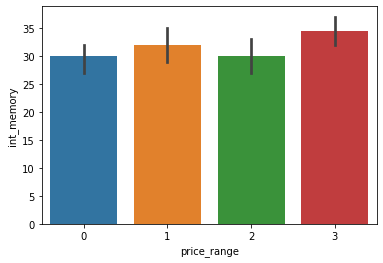

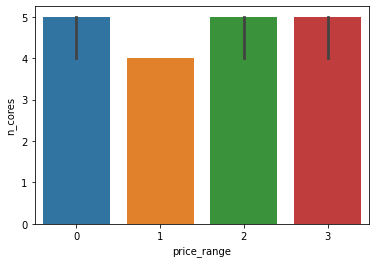

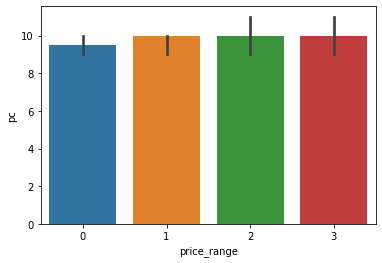

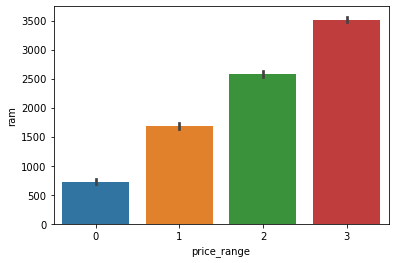

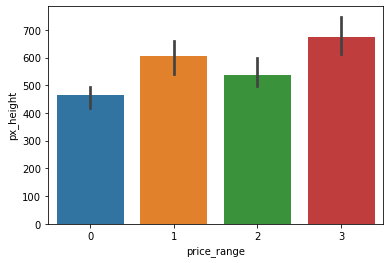

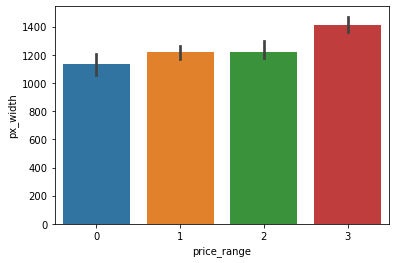

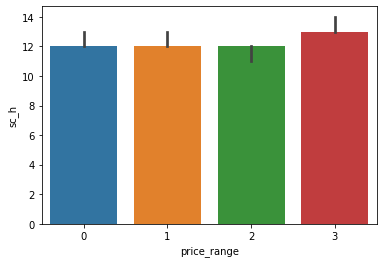

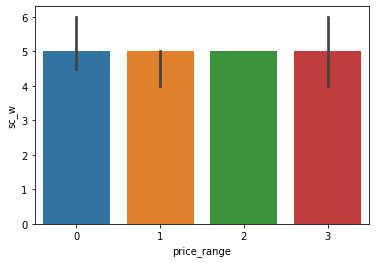

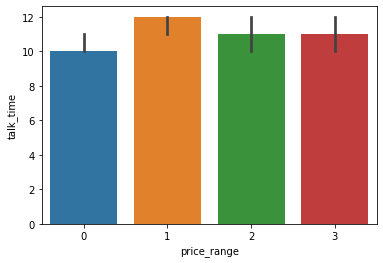

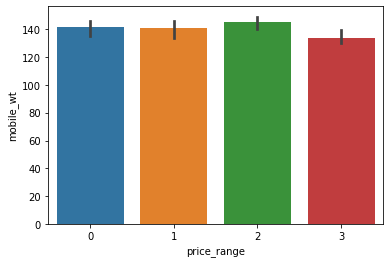

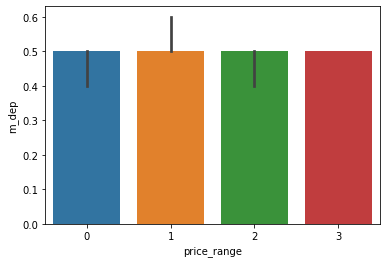

In [69]:
for i in non_cat:
    sns.barplot(y=i,x='price_range', data=df, estimator=np.median)
    plt.show()


In [70]:
kolom=[]
hasil=[]
for i in non_cat:    
    kolom.append(i)
    stats, p_val= kruskal(*[df[df['price_range'] == x][i] for x in df['price_range'].unique()])
    if p_val <= 0.05:
        hasil.append('Beda nyata')
    else:
        hasil.append('Tidak berbeda nyata')

pd.DataFrame({'nama_kolom':kolom,'hasil_tes':hasil})

,nama_kolom,hasil_tes
0,battery_power,Beda nyata
1,clock_speed,Tidak berbeda nyata
2,fc,Tidak berbeda nyata
3,int_memory,Beda nyata
4,n_cores,Beda nyata
5,pc,Tidak berbeda nyata
6,ram,Beda nyata
7,px_height,Beda nyata
8,px_width,Beda nyata
9,sc_h,Tidak berbeda nyata


Berikut adalah tabel ringkasan hasil uji Kruskal Wallis pada masing-masing fitur. Perlu diperhatikan bahwa, dari hasil uji, kita hanya bisa tahu bahwa ada perbedaan nyata di setidaknya 2 kelas pada data, tapi kita tidak bisa tahu kelas mana yang berbeda.  

Dari hasil uji di atas, bisa dilihat bahwa spesifikasi yang tidak terlalu mempengaruhi performa telepon genggam, seperti ukuran piksel kamera, kecepatan _core_ dan ukuran dimensi telepon genggam, tidak membuat harga telepon genggam masuk ke kelas yang berbeda. Spesifikasi seperti, ukuran baterai, RAM, memori internal, piksel layar dan berat telepon genggam lebih berpengaruh terhadap performa telepon genggam juga berpengaruh terhadap perbedaan harga.
yang 
Perbedaan yang paling mencolok terdapat pada fitur RAM, di mana pada kelas `price_range` yang lebih kecil median dari `ram` juga lebih kecil.  

Untuk melihat lebih lanjut hubungan antara tiap fitur numerik dengan target data, mari kita lakukan uji korelasi spearman.

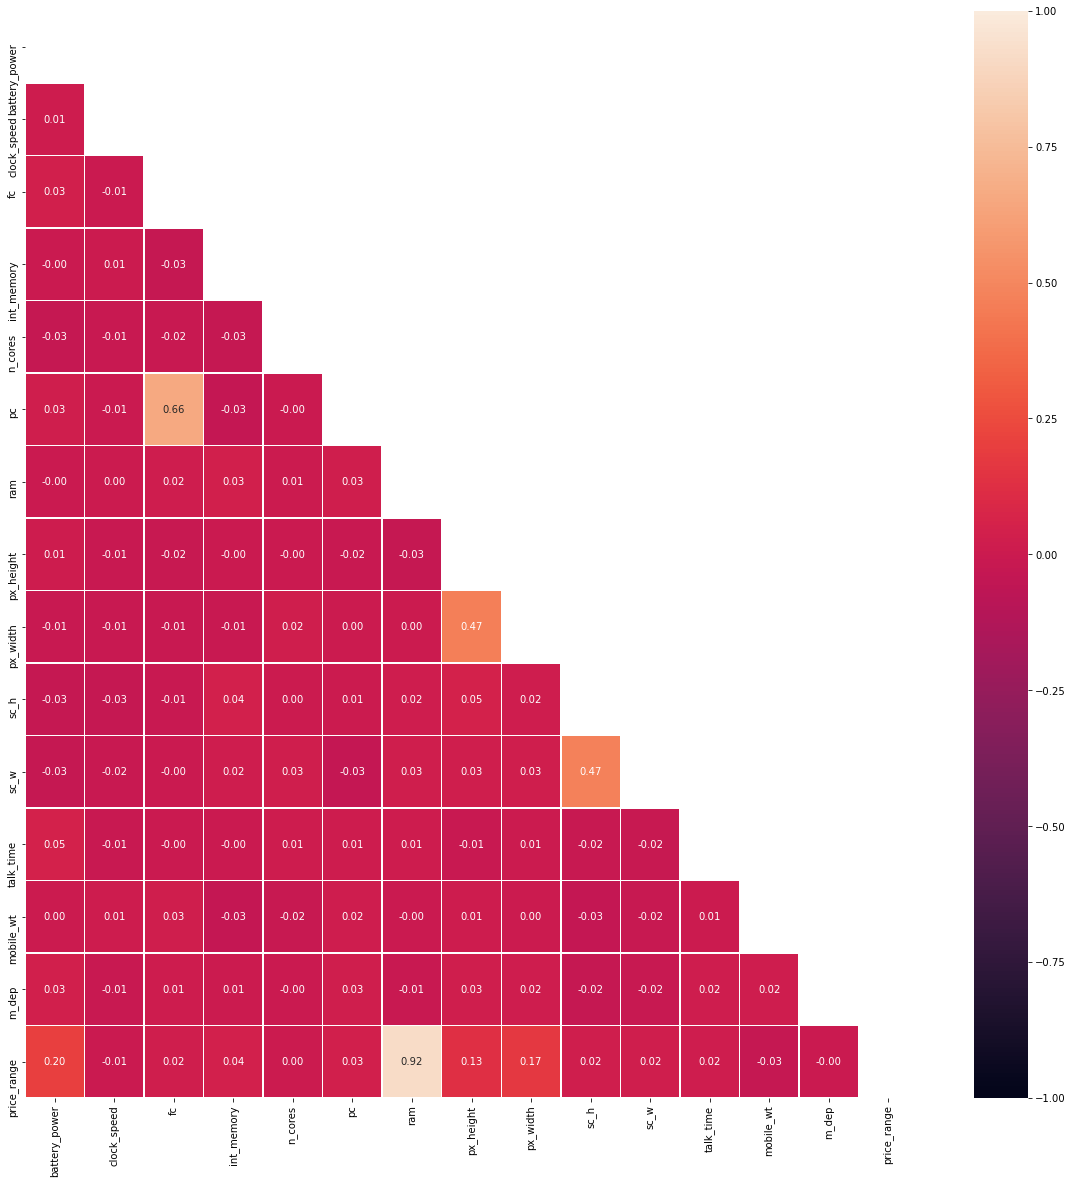

In [71]:
plt.figure(figsize=(20,20))
dropSelf = np.zeros_like(df_corr)
dropSelf[np.triu_indices_from(dropSelf)] =True
sns.heatmap(df_corr,vmin=-1,vmax=1,mask=dropSelf,linewidths=0.5, annot=True, fmt=".2f")

Hasil uji korelasi menunjukkan bahwa hanya fitur `ram` yang memiliki hubungan korelasi positif yang sangat kuat dengan target `price_range`, dengan nilai **0.92**. Kebanyakan fitur-fitur lain memiliki nilai korelasi hampir 0, atau tidak ada hunbungan sama sekali.

## Categorical

Sekarang, mari kita lihat fitur kategorikal dari dataset _Mobil Price Classification_.  

Fitur-fitur kategorikal yang kita punya adalah `blue`, `dual_sim`, `four_g`, `three_g`, `touch_screen`,dan `wifi`, kesemuanya berisikan data binari dengan 0 mewakili tidak punya dan 1 mewakili punya. Mari kita lihat proposi nilai 0 dan 1 di masing-masing fitur berdasarkan `price_range`.

In [72]:
cat=['blue','dual_sim','four_g','three_g','touch_screen','wifi']

In [73]:
for i in cat:
    df_ct=pd.crosstab(df['price_range'],df[i],normalize='all')
    display(df_ct)

blue,0,1
price_range,,
0,0.1285,0.1215
1,0.1275,0.1225
2,0.1285,0.1215
3,0.1205,0.1295


dual_sim,0,1
price_range,,
0,0.1250,0.1250
1,0.1225,0.1275
2,0.1255,0.1245
3,0.1175,0.1325


four_g,0,1
price_range,,
0,0.1205,0.1295
1,0.1190,0.1310
2,0.1265,0.1235
3,0.1125,0.1375


three_g,0,1
price_range,,
0,0.0635,0.1865
1,0.0610,0.1890
2,0.0565,0.1935
3,0.0575,0.1925


touch_screen,0,1
price_range,,
0,0.1190,0.1310
1,0.1195,0.1305
2,0.1325,0.1175
3,0.1260,0.1240


wifi,0,1
price_range,,
0,0.126,0.124
1,0.124,0.126
2,0.124,0.126
3,0.119,0.131


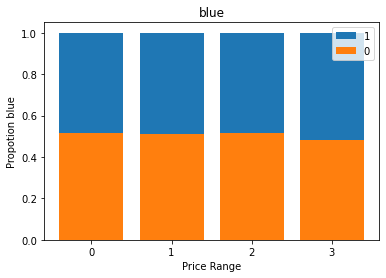

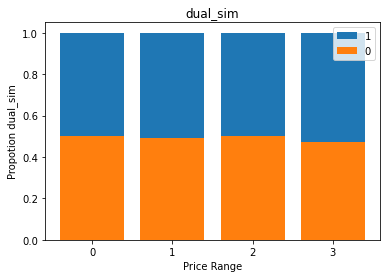

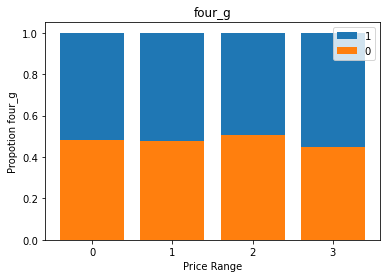

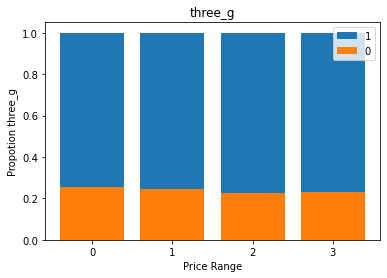

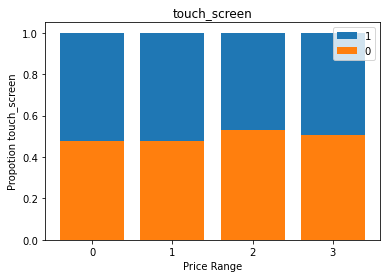

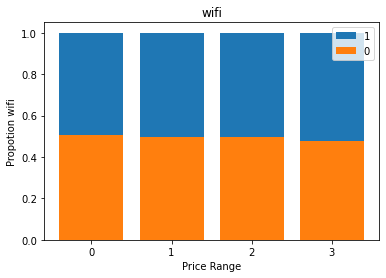

In [99]:
for i in cat:
    ct=pd.crosstab(df['price_range'],df[i],normalize='index').reset_index()
    ct['total']=ct[0]+ct[1]

    plt.bar(np.arange(0,4),ct['total'])
    plt.bar(np.arange(0,4),ct[0])
    plt.xlabel('Price Range')
    plt.ylabel(f'Propotion {i}')
    plt.legend([1,0])
    plt.xticks(np.arange(0,4))
    plt.title(i)
    plt.show()

Kalau dilihat sekilas dari tabel dan grafik di atas, tidak ada perbedaan proporsi antar kelas yang berarti. Untuk memastikan, mari kita cek dengan uji chi square.

In [102]:
kolom=[]
hasil=[]
for i in cat:  
    kolom.append(i)  
    ct=pd.crosstab(df['price_range'],df[i],normalize='index').reset_index()
    
    stats, pval, dof, expected=chi2_contingency(ct)

    if pval<=0.05:
        hasil.append('Tidak ada hubungan')
    else:
        hasil.append('Tidak ada hubungan')
pd.DataFrame({'nama_kolom':kolom,'hasil_tes':hasil})

,nama_kolom,hasil_tes
0,blue,Tidak ada hubungan
1,dual_sim,Tidak ada hubungan
2,four_g,Tidak ada hubungan
3,three_g,Tidak ada hubungan
4,touch_screen,Tidak ada hubungan
5,wifi,Tidak ada hubungan


Bisa dilihat, bahwa fitur-fitur seperti wifi, bluetooth, 4g dan 3g tidak memiliki hubungan berarti dengan kelas harga telepon genggam.

## Simpulan EDA

Dari semua fitur yang ada, fitur `ram` memiliki hubungan yang paling kuat dengan data target. Untuk menyederhanakan proses modeling, maka saya akan memakai hanya fitur `ram` ke depannya. Karena data `ram` sudan berupa numerik dengan distribusi cenderung uniform, maka tidak dilakukan preprosessing sebelum kita masuk ke _modelling_.

# Modelling

Pada bagian ini, saya akan fokus pada penjelasan metrik evaluasi _classification report_ dan _confusion matrix_. Jadi, saya akan menggunakan model logistic regresi, dengan `ram` sebagai fitur dan `price_range` sebagai target.

In [106]:
#library
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler,RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [77]:
x= df[['ram']]
y=df['price_range']

In [78]:
# splitting data
x_train,x_test,y_train,y_test= train_test_split(x, y, stratify=y, test_size=0.2, random_state=2020)

In [79]:
model= LogisticRegression()
model.fit(x_train,y_train)
y_predict=model.predict(x_test)

# Model Evaluation

Mari kita lihat hasil evaluasi dari model sederhana yang sudah kita buat.

## Confusion Matrix
_Confusion Matrix_ adalah matriks yang berisi jumlah hasil prediksi tiap kelas dibandingkan dengan data actualnya. 
Pada dasarnya ada 4 kemungkinan hasil yang dirangkum oleh matriks ini:  
* _True Positive_: ketika hasil prediksi positif dan kelas aktual benar positif
* _True Negative_: ketika hasil prediksi negatif dan kelas aktual benar negatif
* _False Positive_: ketika hasil prediksi positif, padahal kelas aktual adalah negatif
* _False Negative_: ketika hasil prediksi negatif, padahal kelas aktual adalah positif

<img src = 'https://miro.medium.com/max/1000/1*fxiTNIgOyvAombPJx5KGeA.png' height = 400 width= 500>  

Pada klasifikasi binari, cara membaca kemungkinan hasil di _Confusion Matrix_ cukup intuitif, tapi pada klasifikasi multikelas, hal ini bisa cukup membingungkan.

In [81]:
df_con=pd.DataFrame(confusion_matrix(y_test,y_predict),
    index=pd.Index(['0 (low cost)', '1 (medium cost)','2 (high cost)', '3 (very high cost)'], name='Actual Label:'),
    columns=pd.Index(['0 (low cost)', '1 (medium cost)','2 (high cost)', '3 (very high cost)'], name='Predicted:'))
df_con

Predicted:,0 (low cost),1 (medium cost),2 (high cost),3 (very high cost)
Actual Label:,,,,
0 (low cost),79,21,0,0
1 (medium cost),9,72,19,0
2 (high cost),2,17,58,23
3 (very high cost),0,0,15,85


Tabel di atas adalah matriks hasil dari _modelling_ kita. Karena data target kita memiliki 4 kelas, maka matriks yang dihasilkan berukuran 4x4. Sekarang, bagaimana cara kita membaca matriks ini?  

Pertama-tama, kita perlu menentukan kelas positif dan kelas negatif dari matriks kita. Pada klasifikasi binari, kelas positif adalah kelas yang diwakilkan dengan angka 1, pada klasifikasi multikelas, kelas positif adalah kelas yang ingin kita hitung metriknya.  

Misal, kita ingin menghitung metrik pada kelas 0 (_low cost_), maka kelas 0 adalah kelas positif, sedangkan kelas 1 (_medium cos),2 (_high cost_), 3 (_very high cost_) adalah kelas negatif.

In [82]:
idx = pd.IndexSlice
slice_=idx['0 (low cost)','0 (low cost)']
df_con.style.set_properties(**{'background-color': '#C5E1A5'}, subset=slice_)

Predicted:,0 (low cost),1 (medium cost),2 (high cost),3 (very high cost)
Actual Label:,,,,
0 (low cost),79,21,0,0
1 (medium cost),9,72,19,0
2 (high cost),2,17,58,23
3 (very high cost),0,0,15,85


Setelah penentuan kelas positif, kita bisa menentukan hasil **True Positive** pada matriks, yaitu yang baik hasil prediksi maupun data aktualnya adalah kelas 0, atau posisi kiri atas pada tabel di atas.

In [83]:
idx = pd.IndexSlice
slice_=idx['1 (medium cost)':'3 (very high cost)','0 (low cost)']
df_con.style.set_properties(**{'background-color': '#DAF7A6'}, subset=slice_)

Predicted:,0 (low cost),1 (medium cost),2 (high cost),3 (very high cost)
Actual Label:,,,,
0 (low cost),79,21,0,0
1 (medium cost),9,72,19,0
2 (high cost),2,17,58,23
3 (very high cost),0,0,15,85


Pada posisi vertikal dari hasil _True Positif_, kita mendapati hasil prediksi yang dianggap kelas 0, padahal kelas aktualnya bukan kelas 0, atau hasil **False Positive**.

In [85]:
idx = pd.IndexSlice
slice_=idx['0 (low cost)','1 (medium cost)':'3 (very high cost)']
df_con.style.set_properties(**{'background-color': '#F1948A'}, subset=slice_)

Predicted:,0 (low cost),1 (medium cost),2 (high cost),3 (very high cost)
Actual Label:,,,,
0 (low cost),79,21,0,0
1 (medium cost),9,72,19,0
2 (high cost),2,17,58,23
3 (very high cost),0,0,15,85


Pada posisi horizontal dari hasil _True Positif_, kita mendapati hasil prediksi yang dianggap bukan kelas 0, padahal kelas aktualnya adalah kelas 0, atau hasil **False Negative**.

In [84]:
idx = pd.IndexSlice
slice_=idx['1 (medium cost)':'3 (very high cost)','1 (medium cost)':'3 (very high cost)']
df_con.style.set_properties(**{'background-color': '#D98880'}, subset=slice_)

Predicted:,0 (low cost),1 (medium cost),2 (high cost),3 (very high cost)
Actual Label:,,,,
0 (low cost),79,21,0,0
1 (medium cost),9,72,19,0
2 (high cost),2,17,58,23
3 (very high cost),0,0,15,85


Sisa dari matriks adalah hasil **True Negative**, data yang diprediksi bukan kelas 0 dan memang bukan kelas 0.  

Jika dirangkum, maka cara membaca _Confusion Matrix_ data _Mobile Price Classification_ ketika kelas 0 adalah kelas positif adalah sebagai berikut.  

![confusionmatrix.png](confusionmatrix.png)

Contoh lain, kali ini kita memakai kelas 2 (_high cost_) sebagai kelas positif, maka cara membaca _Confusion Matrix_nya adalah sebagai berikut.
![confusionmatrix.png](conmat2.png)

## Classification report  

Dari _Confusion Matrix_, kita bisa menghitung metrik-metrik evaluasi untuk klasifikasi seperti akurasi, _recall_, _precision_ dan _f1-score_. Metrik-metrik diringkas dalam _Classification report_ yang bisa kita pakai untuk melihat performa model secara umum. Metrik yang dipakai bisa disesuaikan dengan kondisi data dan keperluan bisnis serta tujuan dari pembuatan _machine learning_.

In [80]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       100
           1       0.65      0.72      0.69       100
           2       0.63      0.58      0.60       100
           3       0.79      0.85      0.82       100

    accuracy                           0.73       400
   macro avg       0.74      0.73      0.73       400
weighted avg       0.74      0.73      0.73       400



_Classification report_ pada klasifikasi multikelas menunjukan nilai metrik pada setiap kelas yang ada di data target, dibandingkan 2 kelas di klasifikasi binari. Jika pada klasifikasi binari kita fokus pada nilai metrik evaluasi kelas positif (1), pada klasifikasi multikelas, kita bisa memanfaatkan _macro average_ dan _weighted average_.  

_Macro average_ adalah rata-rata dari metrik di setiap kelas, bisa kita pakai ketika jumlah data target di setiap kelas seimbang. *Weighted average* memberikan bobot sesuai dengan jumlah data di setiap kelas data target dalam perhitungan rata-rata dan cocok dipakai ketika jumlah data di setiap kelas tidak seimbang.  

Selain itu, pada kasus seperti di dataset _Mobile Phone Classification_, di mana kita ingin memprediksi range harga telepon genggam berdasarkan spesifikasinya dan di mana data targetnya tersebar secara merata, metrik akurasi bisa dipakai.

Penggunaan recall, precision dan f1 score pada masing-masing kelas bisa disesuaikan dengan keperluan bisnis, dan bisa dipakai ketika kita ingin fokus pada salah satu atau beberapa kelas saja.

## Using Customized Scoring for Model Selection

Kita sudah mempelajari _Confusion Matrix_ dan metrik evaluasinya pada klasifikasi multikelas. Sekarang, jika bagaimana penerapannya pada pemilihan model?  

In [86]:
from sklearn.metrics import SCORERS, make_scorer, precision_score

In [87]:
SCORERS

{'explained_variance': make_scorer(explained_variance_score),
 'r2': make_scorer(r2_score),
 'max_error': make_scorer(max_error, greater_is_better=False),
 'neg_median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False),
 'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
 'neg_mean_squared_log_error': make_scorer(mean_squared_log_error, greater_is_better=False),
 'neg_root_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
 'neg_mean_poisson_deviance': make_scorer(mean_poisson_deviance, greater_is_better=False),
 'neg_mean_gamma_deviance': make_scorer(mean_gamma_deviance, greater_is_better=False),
 'accuracy': make_scorer(accuracy_score),
 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True),
 'roc_auc_ovr': make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr),
 'roc_auc_ovo': make_sc

Pada metode SCORERS dari modul metric di *library* sklearn kita bisa melihat semua metrik evaluasi bawaan pada sklearn secara lebih spesifik. Misal pada metrik evaluasi precisionm tertulis seperti ini: 
>'precision': make_scorer(precision_score, average=binary)

Ini artinya, metrik evaluasi precision hanya dapat digunakan pada kasus klasifikasi. Pada kasus multikelas, kita bisa memakai `precision macro`:

>'precision_macro': make_scorer(precision_score, pos_label=None, average=macro)

Namun, bisa dilihat bahwa `precision macro` mengambil rata-rata dari nilai precision di setiap kelas. Bagaimana bila kita ingin fokus ke satu atau dua kelas saja?

Di *library* sklearn ada metode `make_scorer` yang bisa kita manfaatkan untuk membuat metrik evaluasi yang bisa kita sesuaikan dengan kebutuhan kita.

Misal, perusahaan tempat kita bekerja fokus pada produksi telepon genggam dengan harga jual yang murah, sehingga ketika meembuat model, kita ingin fokus pada `price_range` kelas 0. Pada kasus ini, kesalahan FP bisa merugikan perusahaan; telepon genggam dengan spesifikasi tinggi, dan kemungkinan besar memiliki ongkos produksi yang lebih tinggi, diprediksi memiliki harga jual rendah. Karenanya, kita ingin menekan angka FP dari kelas 0 serendah mungkin, dan metrik evaluasi precision kelas 0 bisa kita pakai dalam pemilihan model.  

Dengan memanfaatkan metode `make_scorer` kita bisa membuat metrik evaluasi precision kelas 0 dengan cara berikut.

In [107]:
make_scorer(precision_score, labels=[0], average='macro')(model,x_test,y_test)

0.8777777777777778

Hasilnya sesuai dengan precision kelas 0 pada _Classification report_.

In [89]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       100
           1       0.65      0.72      0.69       100
           2       0.63      0.58      0.60       100
           3       0.79      0.85      0.82       100

    accuracy                           0.73       400
   macro avg       0.74      0.73      0.73       400
weighted avg       0.74      0.73      0.73       400



Jadi, kita bisa membuat metrik _customized_ dengan make scorer dan menyimpannya pada suatu variabel untuk digunakan dalam _cross validation_, sehingga kita bisa memilih model denga  performa paling baik dan stabil seperti contoh di bawah ini.

In [108]:
prec_0=make_scorer(precision_score, labels=[0], average='macro')
cross_val_score(model,x_train,y_train,scoring=prec_0)

array([0.8125    , 0.92105263, 0.82222222, 0.8961039 , 0.8125    ])

# Kesimpulan

Cara evaluasi pada klasifikasi binari dan multikelas memiliki sedikit perbedaan. Jumlah kelas yang lebih banyak pada klasifikasi multikelas bisa menyebabkan kebingungan dalam intepretasi _Confusion Matrix_. Namun, pada hakikatnya, cara intepretasi _Confusion Matrix_ di kedua metode masihlah sama.  

Penggunaan metrik evaluasi dalam keperluan bisnin juga memiliki konteks yang sama, hanya saja, kemungkinan metric yang kita perlukan tidak tercakup dalam metrik bawaan di sklearn. Pada saat seperti itu, kita bisa membuat metrik sesuai keperluan kita dengan metode `make_scorer`

Bacaan lebih lanjut:  

[https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/](https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/)  
[https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd)  
[https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html](https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html)   
[https://scikit-learn.org/stable/modules/model_evaluation.html](https://scikit-learn.org/stable/modules/model_evaluation.html)  